### Import required packages, set some settings

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [7]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 4)

### Generate regression dataset

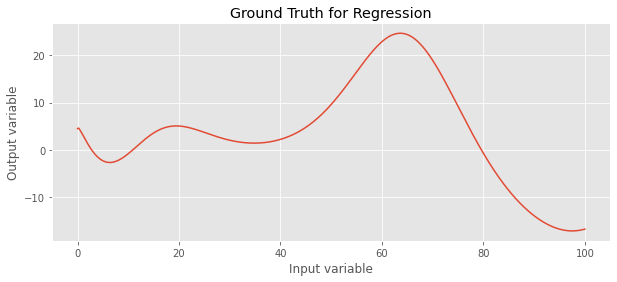

In [8]:
def ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return 15*np.cos(0.1/(0.001*x+0.02)) + 3*np.exp(0.5*np.sin((x**0.9-3)/5))/((x+0.01)**(-0.5)) -0.005*x**2

xs = np.linspace(0, 100, 500)
ys = ground_truth(xs)
plt.title("Ground Truth for Regression")
plt.plot(xs, ys)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.show()

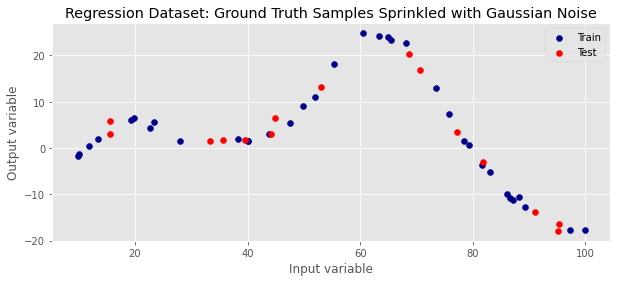

In [9]:
def generate_dataset(size=50, noise=1, split=0.3):
    xs = np.random.uniform(0, 100, size)
    ys = ground_truth(xs) + np.random.normal(0, noise, size)
    return train_test_split(xs, ys, test_size=split, random_state=13)

x_tr, x_te, y_tr, y_te = generate_dataset()
plt.title("Regression Dataset: Ground Truth Samples Sprinkled with Gaussian Noise")
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

### Control test: deterministic MLP

##### Build model

In [10]:
model = torch.nn.Sequential(
    torch.nn.Linear(1, 100),
    torch.nn.ELU(),
    torch.nn.Linear(100, 100),
    torch.nn.ELU(),
    torch.nn.Linear(100, 100),
    torch.nn.ELU(),
    torch.nn.Linear(100, 100),
    torch.nn.ELU(),
    torch.nn.Linear(100, 1),
)

loss = torch.nn.MSELoss()
opt = torch.optim.SGD(
    model.parameters(), 
    lr=0.00005,  # learning rate
)

##### Train model

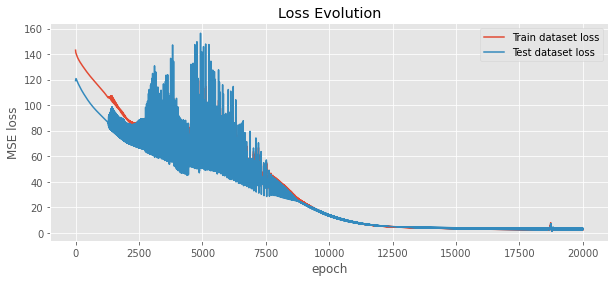

In [11]:
tr_loss_evo = []
te_loss_evo = []

for _ in range(20000):  # epochs
    y_tr_pred = model(x_tr)
    l = loss(y_tr_pred, y_tr)
    tr_loss_evo.append(l.item())
    te_loss_evo.append(loss(model(x_te), y_te).item())
    model.zero_grad()
    l.backward()
    opt.step()

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

##### Test model

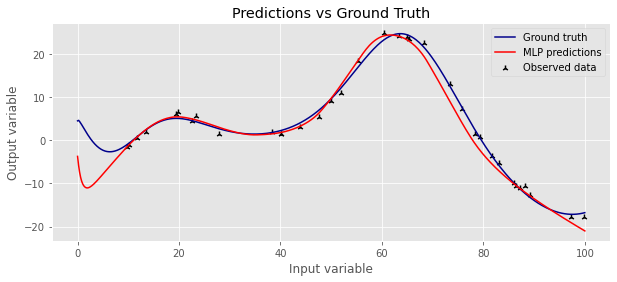

In [12]:
xs = np.linspace(0, 100, 500)
yps = model(torch.FloatTensor(xs).unsqueeze(-1)).detach().numpy()
ys = ground_truth(xs)
plt.title("Predictions vs Ground Truth")
plt.plot(xs, ys, color='darkblue', label='Ground truth')
plt.plot(xs, yps, color='red', label='MLP predictions')
plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

### Bayesian neural network

##### Theory & assumptions

- The neural network is a function that returns an output given the input and the model parameters, $$\hat{y} = f(x, \boldsymbol{\theta})$$
- We assume (with i.i.d data) a Gaussian likelihood, $$\mathcal{L}(\boldsymbol{\theta}) = p(\mathcal{D}|\boldsymbol{\theta}) = \prod_n\mathcal{N}(y_n|f(x_n,\boldsymbol{\theta}), \sigma^2_{noise})$$ where $\sigma_{noise}$ is the variance parameter of the output neuron
- We take independent Gaussian priors over the parameters, $$p(\boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\theta}|\boldsymbol{0}, \sigma_p^2\mathbf{I})$$ where $\sigma_p$ is a variance hyperparameter
- Since the network function is highly nonlinear, the true posterior distribution is intractable and so we resort to variational inference. Namely, we resort to a mean-field (diagonal) Gaussian variational distribution: $$q_\phi(\boldsymbol{\theta}) = \prod_{i=1}^{|\boldsymbol{\theta}|}\mathcal{N}(\theta_i|\mu_i, \sigma_i^2)$$ where $\phi = \{\mu_i, \sigma_i\}$ are the variational parameters
- As usual in variational inference, we wish to select the variational parameters by minimising the Kullback-Leibler (KL) divergence between the variational distribution and the posterior, however as usual this too is intractable and so we optimise the evidence lower-bound (ELBO) instead, which can be written as: $$ELBO = \mathbb{E}_{\theta\sim q_{\phi}}[\log\mathcal{L}(\boldsymbol{\theta})] - KL[q_{\phi}||p(\boldsymbol{\theta})]$$ Looking at the two terms, we see that maximising the ELBO maximises the expected log likelihood (fit to the data) while minimising the KL divergence between the variational distribution and the prior distribution (the standard Bayesian "Occam's Razor" tradeoff)
- Since both the variational and prior distributions are taken to be Gaussian, the KL divergence between them can be calculated in closed form. Taking $k$ to denote the number of parameters, $$KL[q_{\phi}||p(\boldsymbol{\theta})] = \frac{1}{2}(\sum_i^k\frac{\mu_i^2 + \sigma_i^2}{\sigma_p^2} - 2\sum_i^k\log\frac{\sigma_i}{\sigma_p} - k)$$
- Thus the ELBO can be written as: $$ELBO = \mathbb{E}_{\theta\sim q_{\phi}}[\log\mathcal{L}(\boldsymbol{\theta})] - \frac{1}{2}\sum_i^k[\frac{\mu_i^2 + \sigma_i^2}{\sigma_p^2} - 2\log\frac{\sigma_i}{\sigma_p} - 1]$$ where we can estimate the first term by sampling and using the *reparameterisation trick* (Kingma and Welling, 2014)

Random notes

- loss is no longer going to be MSE, instead it will be negative ELBO (because we want to maximise ELBO...). We will need to define this loss manually
- how do we "make the parameters have distributions" in pytorch? *we define two networks, one for variational means, one for variational variances*
- the parameters argument in the optimiser will need to be different
- how do we sample from the log likelihood?

##### Build model

In [17]:
class BNN(torch.nn.Module):

    def __init__(self):
        super().__init__()

        # variational means for network params 
        self.mu_q = torch.nn.Sequential(
            torch.nn.Linear(1, 100),
            torch.nn.ELU(),
            torch.nn.Linear(100, 100),
            torch.nn.ELU(),
            torch.nn.Linear(100, 100),
            torch.nn.ELU(),
            torch.nn.Linear(100, 100),
            torch.nn.ELU(),
            torch.nn.Linear(100, 1),
        )

        # variational log variances for network params
        # use log because log variance can be negative, variance cannot
        self.logvar_q = torch.nn.Sequential(
            torch.nn.Linear(1, 100),
            torch.nn.ELU(),
            torch.nn.Linear(100, 100),
            torch.nn.ELU(),
            torch.nn.Linear(100, 100),
            torch.nn.ELU(),
            torch.nn.Linear(100, 100),
            torch.nn.ELU(),
            torch.nn.Linear(100, 1),
        )
    
    def reparameterise(self, mu, logvar):
        sig = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(sig)
        return mu + sig*epsilon

    def forward(self, x):
        mu = self.mu_q(x)
        logvar = self.logvar_q(x)
        return self.reparameterise(mu, logvar), mu, logvar

# Gaussian log likelihood for a single datapoint
def ll(y, mu, logvar):
    sig = torch.exp(0.5 * logvar)
    return - 0.5 * torch.log(2 * np.pi * sig**2) - (y - mu)**2 / (2 * sig**2)

# compute ELBO
def elbo(y_pred, y, mu, logvar, prior_var):
    exp_ll = ll(y, mu, logvar).mean() # expected log likelihood
    # or do we use the below from Kingma and Welling 2013?
    # reconstruction_error = (0.5 * (y - y_pred)**2).sum()

    kl = 0.5 * torch.sum(((mu**2 + torch.exp(logvar)) / prior_var) - logvar + torch.log(prior_var) - 1)

    return (exp_ll - kl).sum()

# take negative of elbo as loss since we have SGD at our disposal, not SGA
def elbo_loss(y_pred, y, mu, logvar, prior_var):
    return - elbo(y_pred, y, mu, logvar, prior_var)

In [22]:
bnn_model = BNN()

prior_var = torch.tensor([1.0])

opt = torch.optim.SGD(
    bnn_model.parameters(),
    lr = 0.000001
)

##### Train model

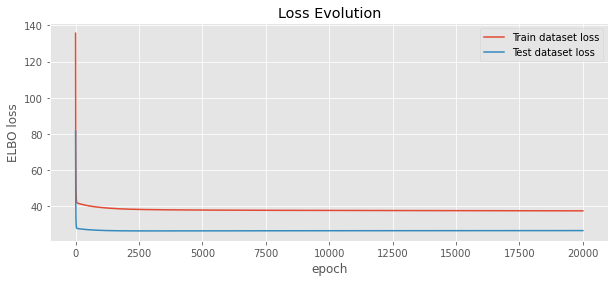

In [23]:
tr_loss_evo = []
te_loss_evo = []

for _ in range(20000):  # epochs
    bnn_model.zero_grad()

    y_tr_pred, mu_tr, logvar_tr = bnn_model(x_tr)
    l = elbo_loss(y_tr_pred, y_tr, mu_tr, logvar_tr, prior_var)
    tr_loss_evo.append(l.item())

    y_te_pred, mu_te, logvar_te = bnn_model(x_te)
    te_loss_evo.append(elbo_loss(y_te_pred, y_te, mu_te, logvar_te, prior_var).item())

    l.backward()
    opt.step()

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

##### Test model

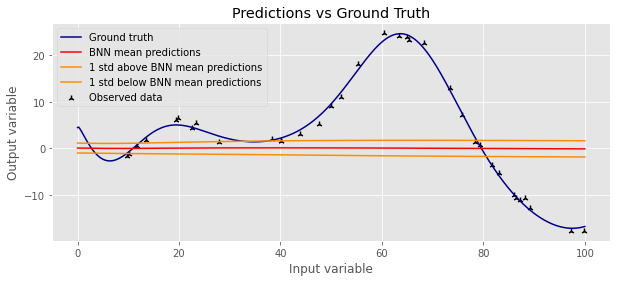

In [24]:
xs = np.linspace(0, 100, 500)
sample, mu, logvar = bnn_model(torch.FloatTensor(xs).unsqueeze(-1))
mu, logvar = mu.detach().numpy(), logvar.detach().numpy()
ys = ground_truth(xs)
plt.title("Predictions vs Ground Truth")
plt.plot(xs, ys, color='darkblue', label='Ground truth')
plt.plot(xs, mu, color='red', label='BNN mean predictions')
plt.plot(xs, mu + np.sqrt(np.exp(logvar)), color='darkorange', label='1 std above BNN mean predictions')
plt.plot(xs, mu - np.sqrt(np.exp(logvar)), color='darkorange', label='1 std below BNN mean predictions')
plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()